# Titanic

Overview\
The data has been split into two groups:

training set (train.csv)\
test set (test.csv)\
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
____________________________
Variable	Definition	Key\
survival	Survival	0 = No, 1 = Yes\
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd\
sex	Sex	\
Age	Age in years	\
sibsp	# of siblings / spouses aboard the Titanic	\
parch	# of parents / children aboard the Titanic	\
ticket	Ticket number	\
fare	Passenger fare	\
cabin	Cabin number	\
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton\
___________________________________
Variable Notes\
pclass: A proxy for socio-economic status (SES)\
1st = Upper\
2nd = Middle\
3rd = Lower\

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5\

sibsp: The dataset defines family relations in this way...\
Sibling = brother, sister, stepbrother, stepsister\
Spouse = husband, wife (mistresses and fiancés were ignored)\

parch: The dataset defines family relations in this way...\
Parent = mother, father\
Child = daughter, son, stepdaughter, stepson\
Some children travelled only with a nanny, therefore parch=0 for them.\


In [1]:
import pandas as pd
from pandas import get_dummies
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

## Load Data

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

In [3]:
raw_train.head()
shapeTrain,shapeTest = raw_train.shape,raw_test.shape

In [4]:
X_concat = pd.concat([raw_train.drop(columns=['Survived']),raw_test])
shapeTotal = X_concat.shape
print('Shape of training data:',shapeTrain,'Shape of testing data:',shapeTest)
X_concat.head()

Shape of training data: (891, 12) Shape of testing data: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing

### Check NaN values

In [5]:
X_concat.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [6]:
X_concat['Age'] = X_concat['Age'].fillna(0)
X_concat['Cabin'] = X_concat['Cabin'].fillna('NAN')
X_concat['Embarked'] = X_concat['Embarked'].fillna('NAN')
X_concat['Fare'] = X_concat['Fare'].fillna(999)
X_concat.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [7]:
def agecheck(age):
    if age <= 18:
        return('kid')
    # elif age<= 17:
    #     return('teen')
    elif age <= 45:
        return('adult')
    # elif age <= 65:
    #     return('old')
    else:
        return('old')
    
def cabinencode(cabin):
    if 'NAN' not in cabin:
        return 'Y'
    # cabin[0]
    else:
        return 'N'
X_concat['AgeClass'] = X_concat['Age'].apply(agecheck)
X_concat['CabinYN'] = X_concat['Cabin'].apply(cabinencode)
X_concat.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeClass,CabinYN
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NAN,S,adult,N
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,Y
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NAN,S,adult,N
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,Y
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NAN,S,adult,N


In [8]:
cols = ['PassengerId',
       'Name',
       'Ticket',
       'Cabin',
       ]
X_clean = X_concat.drop(columns = cols)
X_processed = pd.get_dummies(X_clean)
df = X_processed[:shapeTrain[0]]

Pclass           -0.338481
Age               0.010539
SibSp            -0.035322
Parch             0.081629
Fare              0.257307
Sex_female        0.543351
Sex_male         -0.543351
Embarked_C        0.168240
Embarked_NAN      0.060095
Embarked_Q        0.003650
Embarked_S       -0.155660
AgeClass_adult    0.003830
AgeClass_kid      0.003411
AgeClass_old     -0.011082
CabinYN_N        -0.316912
CabinYN_Y         0.316912
R                 1.000000
Name: R, dtype: float64


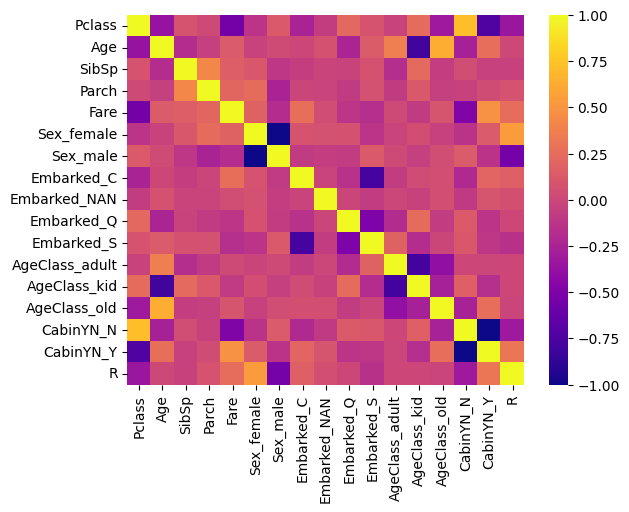

In [9]:
dfvis = df.copy()
dfvis['R'] = raw_train['Survived']
sns.heatmap(dfvis.corr(),cmap = 'plasma')
print(dfvis.corr()['R'])
# df = df.dropna()

In [15]:
# X,Y = df.drop(columns = ['Cabin','PassengerId','Ticket','Sex','Parch','SibSp','Name','Embarked']),raw_train['Survived']
X,Y = df,raw_train['Survived']
X.head()
# scaler = preprocessing.StandardScaler().fit(X)
# X = scaler.transform(X)
# print(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
classifiers = {'Random Forest':RandomForestClassifier(), 
               'Decision Tree':DecisionTreeClassifier(),
               'Gradient Boosting':GradientBoostingClassifier(),
               'Logistic Regression':LogisticRegression(),
               'Adaptive Boosting': AdaBoostClassifier(),
              }

In [17]:
names = list(classifiers.keys())
record = []
models = []
for name,cla in classifiers.items():
    print(name)
    pipe = make_pipeline(
                    # StandardScaler(),
                    MinMaxScaler(),
                    # MaxAbsScaler(),
                    cla
                    )
    pipe.fit(X_train,y_train)
    models.append(pipe)
    print(confusion_matrix(y_test,pipe.predict(X_test)))
    print(classification_report(y_test,pipe.predict(X_test)))
    scores = cross_val_score(pipe,X,Y,cv = 10)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    record.append((scores.mean(),scores.std()))
    print('-'*50)

Random Forest
[[158  23]
 [ 32  82]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       181
           1       0.78      0.72      0.75       114

    accuracy                           0.81       295
   macro avg       0.81      0.80      0.80       295
weighted avg       0.81      0.81      0.81       295

0.80 accuracy with a standard deviation of 0.04
--------------------------------------------------
Decision Tree
[[157  24]
 [ 37  77]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       181
           1       0.76      0.68      0.72       114

    accuracy                           0.79       295
   macro avg       0.79      0.77      0.78       295
weighted avg       0.79      0.79      0.79       295

0.80 accuracy with a standard deviation of 0.04
--------------------------------------------------
Gradient Boosting
[[160  21]
 [ 34  80]]
              precision    recall

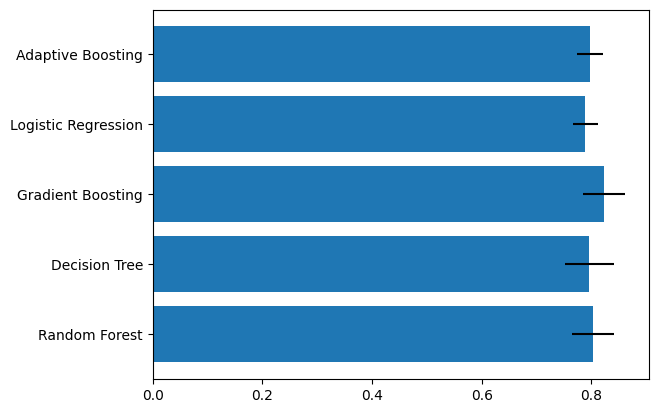

best model: Gradient Boosting


In [18]:
acc = [x for x,y in record]
plt.barh(y = names, width = acc,xerr =[y for x,y in record])
plt.show()
best_model = np.array(names)[acc == max(acc)][0]
print('best model:' ,best_model)


In [19]:
# result = np.zeros(418)
# for md in models:
#     survived = np.array(md.predict(X_processed[shapeTrain[0]:]))
#     result = np.add(result,survived)
# survived = []
# for i in result:
#     if i >= len(models)/2:
#         survived.append(1)
#     else:
#         survived.append(0)
survived = models[name==best_model].predict(X_processed[shapeTrain[0]:])

PassengerId = raw_test['PassengerId']
datadict = {'PassengerId':PassengerId,'Survived':survived}
submission = pd.DataFrame(data = datadict)
submission.head()
submission.to_csv('Submission.csv',index=False)